In [1]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
import seaborn as sns

# Load data

In [2]:
data_train = pd.read_csv('data/danrer11_chopchop_train.csv',index_col=0)
data_test = pd.read_csv('data/danrer11_chopchop_test.csv',index_col=0)

# Transform Data
## One-hot encoding

In [3]:
encoding = {'A':np.array([1,0,0,0]),
            'C':np.array([0,1,0,0]),
            'G':np.array([0,0,1,0]),
            'T':np.array([0,0,0,1])}

def one_hot(guide,encoding):
    data = np.zeros((4,len(guide)))
    assert data.shape == (4,23)
    for i in range(data.shape[-1]):
        data[:,i] = encoding[guide[i]]
    return data

#print(one_hot('CTGATCACGGCTGAAGGACTCGG',encoding))

def batch_one_hot(data,encoding):
    guides = np.zeros((len(data),4,23))
    i=0
    for guide in data['GUIDE']:
        guides[i] = one_hot(guide,encoding)
        i+=1
    return guides

guides_train = batch_one_hot(data_train,encoding)
guides_test = batch_one_hot(data_test,encoding)
print('Train dataset size:',guides_train.shape)
print('Test dataset size:',guides_test.shape)

Train dataset size: (226420, 4, 23)
Test dataset size: (56606, 4, 23)


In [4]:
print(one_hot('CTGATCACGGCTGAAGGACTCGG',encoding))

[[0. 0. 0. 1. 0. 0. 1. 0. 0. 0. 0. 0. 0. 1. 1. 0. 0. 1. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 1. 0. 1. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 1. 0. 1. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 1. 1. 0. 0. 1. 0. 0. 1. 1. 0. 0. 0. 0. 1. 1.]
 [0. 1. 0. 0. 1. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]]


## `Pytorch` data format

In [5]:
class GGEDataset(Dataset):

    def __init__(self, data, transform=None):
        self.data = data
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
            
        sample = self.data[idx]
        if self.transform:
            sample = self.transform(sample)

        return sample.float()
    
transform = transforms.Compose([
        transforms.ToTensor()
    ])
GGE_dataset_train = GGEDataset(data = guides_train, transform = transform)
GGE_dataset_test = GGEDataset(data = guides_test, transform = transform)

trainloader = torch.utils.data.DataLoader(GGE_dataset_train, batch_size=50000,shuffle=False, num_workers=0)
testloader = torch.utils.data.DataLoader(GGE_dataset_test, batch_size=50000,shuffle=False, num_workers=0)

In [6]:
len(GGE_dataset_train)

226420

# Create Autoencoder

In [7]:
class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()

        self.encoder = nn.Sequential(
            nn.Linear(92, 60),
            nn.ReLU(),
            nn.Linear(60, 40),
            nn.ReLU(),
            nn.Linear(40, 30)
        )
        self.decoder = nn.Sequential(
            nn.Linear(30, 40),
            nn.ReLU(),
            nn.Linear(40, 60),
            nn.ReLU(),
            nn.Linear(60, 92),
            nn.Sigmoid()
        )
        
        self.conv1 = nn.Conv2d(1, 6, 2)
        self.pool1 = nn.MaxPool2d(2, 2)
        self.conv2 = nn.ConvTranspose2d(6, 1, 2)
        self.pool2 =nn.MaxUnpool2d(2, 2)

    def forward(self, x):
        x = x.view(-1,1*4*23)
        x = self.encoder(x)
        x = self.decoder(x)
        x = x.view(-1,1,4,23)

        return x

In [8]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

In [9]:
net = Autoencoder().to(device)

## Load model

In [10]:
checkpoint = torch.load('model/autoencoder.pth.tar')
net.load_state_dict(checkpoint['state_dict'])

<All keys matched successfully>

# Train the Logistic model on chopchop data

In [11]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

## extract features

Transfer all the guide from 92 dimension to 30 dimension

In [12]:
trainloader = torch.utils.data.DataLoader(GGE_dataset_train, batch_size=len(GGE_dataset_train),shuffle=False, num_workers=0)
testloader = torch.utils.data.DataLoader(GGE_dataset_test, batch_size=len(GGE_dataset_test),shuffle=False, num_workers=0)

In [13]:
with torch.no_grad():
    for data in trainloader:
        tr_fea = net.encoder(data.view(-1,1*4*23).to(device)).to('cpu')
        # break
print("Data shape: {}".format(tr_fea.shape))
tr_fea

Data shape: torch.Size([226420, 30])


tensor([[ 13.5784,  -4.2706,  -2.8988,  ...,   6.9587, -11.0836,  -8.5389],
        [ 13.8553,   2.9260,  -2.9646,  ...,   1.1597,  -3.6170,   4.3032],
        [  4.2005,  -1.9159,  -1.7123,  ...,   5.3553, -10.7488,  -9.3842],
        ...,
        [  9.8289,   9.3090,  -5.1207,  ...,   9.4204,  -9.4076,  -0.6384],
        [  2.7749,   4.6147, -10.3113,  ...,   3.9229,  -4.0526,   1.1860],
        [ -2.3375,  -1.3460,  -5.7669,  ...,  -0.0944,  -8.8136,   8.5558]])

In [14]:
with torch.no_grad():
    for data in testloader:
        test_fea = net.encoder(data.view(-1,1*4*23).to(device)).to('cpu')
print("Data shape: {}".format(test_fea.shape))


Data shape: torch.Size([56606, 30])


In [15]:
class GeneDataset(object):
    def __init__(self, guide, eff):
        self.target_sequence = guide
        self.efficiency = eff.values
    
    def __getitem__(self, idx):
        seq = self.target_sequence[idx]
        eff = torch.as_tensor(self.efficiency[idx], dtype=torch.float32)
        return seq, eff
    
    def __len__(self):
        return len(self.target_sequence)

In [16]:
chop_cls = lambda x: 0 if x<=50 else 1
data_train["ori_cla"]=data_train.EFFICIENCY.apply(chop_cls)
data_test["ori_cla"]=data_test.EFFICIENCY.apply(chop_cls)

In [17]:
train_size = int(0.8 * len(tr_fea))
vali_size = len(tr_fea) - train_size
tr = GeneDataset(tr_fea[:train_size],data_train["ori_cla"][:train_size])
validation = GeneDataset(tr_fea[train_size:],data_train["ori_cla"][train_size:])

train_size = int(0.8 * len(tr_fea))
vali_size = len(tr_fea) - train_size
tr = GeneDataset(tr_fea[:train_size],data_train['EFFICIENCY'][:train_size]/100)
validation = GeneDataset(tr_fea[train_size:],data_train['EFFICIENCY'][train_size:]/100)

In [18]:
vali_size

45284

In [19]:
test = GeneDataset(test_fea,data_test["ori_cla"])

## get dataloader

In [20]:
chop_trainloader = torch.utils.data.DataLoader(tr, batch_size=128,shuffle=True, num_workers=0)
chop_validloader = torch.utils.data.DataLoader(validation, batch_size=vali_size,shuffle=True, num_workers=0)
chop_testloader = torch.utils.data.DataLoader(test, batch_size=128,shuffle=True, num_workers=0)

In [21]:
tr[0]

(tensor([ 13.5784,  -4.2706,  -2.8988,   4.6056,  -2.8107,   1.2597,  -4.9050,
          -1.1582,   4.5699,  -1.7905,  -3.7577,  -0.2078,   2.1379,  -4.3548,
           4.5876,   8.4380,  -2.3158,  -0.5777,  -0.2357,   2.6147,  -3.9915,
           2.1595,   0.6034,  -3.1596,  -6.8227,   1.8248,  -0.0275,   6.9587,
         -11.0836,  -8.5389]), tensor(0.))

# construct logistic model

In [22]:
# Pytorch线性回归

# 导入库
import torch      
from torch.autograd import Variable     
import torch.nn as nn 
import warnings
warnings.filterwarnings("ignore")

class LogisticModel(nn.Module):
    def __init__(self,in_dim, n_class):
        super(LogisticModel, self).__init__()
        self.l1 = torch.nn.Linear(in_dim, 20)
        self.l2 = torch.nn.Linear(20, 10)
        self.l3 = torch.nn.Linear(10, 1)
        self.sigmoid = torch.nn.Sigmoid()

    def forward(self, x):
        x = self.sigmoid(self.l1(x))
        x = self.sigmoid(self.l2(x))
        y_pred = self.sigmoid(self.l3(x))
        return y_pred
    

In [23]:
# define the model
input_dim = tr[0][0].shape[0]
output_dim = 1
model = LogisticModel(input_dim,output_dim) 

# Construct loss function and optimizer
criterion = torch.nn.BCELoss(size_average=True)
optimizer = torch.optim.SGD(model.parameters(), lr=0.01)

In [24]:
def train(epoch, model, trainloader, validloader,tolerance=0.0001):
    valid_loss_his = []
    train_loss_his = []
    model.train()
    for e in range(epoch):
        train_loss = 0
        for batch_idx, (inputs, targets) in enumerate(trainloader):
            inputs, targets = inputs.to('cpu'), targets.to('cpu')
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
        mean_loss=train_loss/(batch_idx+1)
        train_loss_his.append(mean_loss)
        model.eval()
        with torch.no_grad():
            for valid, tar in validloader:
                valid, tar = valid.to('cpu'), tar.to('cpu')
                opt = model(valid)
                valid_loss = criterion(opt, tar)
        valid_loss_his.append(valid_loss)
        print('Train: Epoch: %d| train_loss: %f|valid_loss: %f'% (e, mean_loss, valid_loss))
        if e >1 and abs(valid_loss_his[-1]-valid_loss_his[-2])<tolerance:
            break
    return train_loss_his, valid_loss_his

In [25]:
# 可继续训练，寻找最优epoch
train_loss_his, valid_loss_his = train(epoch=50, model=model, trainloader=chop_trainloader, validloader=chop_validloader)

Train: Epoch: 0| train_loss: 0.685633|valid_loss: 0.683790
Train: Epoch: 1| train_loss: 0.681240|valid_loss: 0.680759
Train: Epoch: 2| train_loss: 0.677359|valid_loss: 0.675586
Train: Epoch: 3| train_loss: 0.670068|valid_loss: 0.665955
Train: Epoch: 4| train_loss: 0.657764|valid_loss: 0.651589
Train: Epoch: 5| train_loss: 0.643053|valid_loss: 0.637955
Train: Epoch: 6| train_loss: 0.631368|valid_loss: 0.628421
Train: Epoch: 7| train_loss: 0.622385|valid_loss: 0.619661
Train: Epoch: 8| train_loss: 0.612608|valid_loss: 0.608229
Train: Epoch: 9| train_loss: 0.599801|valid_loss: 0.593735
Train: Epoch: 10| train_loss: 0.584678|valid_loss: 0.577511
Train: Epoch: 11| train_loss: 0.568223|valid_loss: 0.560709
Train: Epoch: 12| train_loss: 0.551862|valid_loss: 0.544278
Train: Epoch: 13| train_loss: 0.536084|valid_loss: 0.528994
Train: Epoch: 14| train_loss: 0.521462|valid_loss: 0.515674
Train: Epoch: 15| train_loss: 0.508039|valid_loss: 0.502685
Train: Epoch: 16| train_loss: 0.495730|valid_loss:

In [26]:
chop_pre = model(test_fea)
data_test['pre']=chop_pre.detach().numpy().reshape(1,-1)[0].tolist()

In [27]:
chop_pre_cla = lambda x: 0 if x<=0.5 else 1
data_test["pre_cla"]=data_test.pre.apply(chop_pre_cla)

In [28]:
chop_Y_te = data_test["ori_cla"].values.tolist()
chop_preds = data_test["pre_cla"].values.tolist()
print('Accuracy:', accuracy_score(chop_Y_te,chop_preds))
print('Precision:', precision_score(chop_Y_te,chop_preds))
print('Recall:', recall_score(chop_Y_te,chop_preds))
print('F1-Score:', f1_score(chop_Y_te,chop_preds))

Accuracy: 0.8219093382326962
Precision: 0.8266452170286293
Recall: 0.8668541080912215
F1-Score: 0.8462723210881865


In [29]:
data_test

,GUIDE,EFFICIENCY,CHR,STRAND,TSS,LOCATION,ori_cla,pre,pre_cla
229866,ATTAGTACGCGAACTCATAGCGG,55.34,5,-1,62340897,62340956,1,0.964052,1
110483,ACTGCAGTCGCGATTGGAGGAGG,44.18,1,-1,49498262,49498344,0,0.868224,1
13230,TCGGACAAGAAACTAGCTTTGGG,48.11,11,1,15875002,15874883,0,0.176927,0
244662,CAGCGGAGAAGAGGAGGCCGTGG,48.86,7,1,13491501,13491645,0,0.296259,0
222274,TAAATATGTAAAATATTTCAAGG,29.31,5,-1,32274383,32274243,0,0.071673,0
26004,GAGGAGCCGAGCTAGGCGGAAGG,55.70,12,-1,25845556,25845488,1,0.941890,1
93379,CAGTTCGCGTTTGGTTAAAGTGG,44.76,19,-1,24068242,24068205,0,0.509479,1
24997,TTTACACAGCCTTTTTGGCAGGG,52.34,12,-1,22560132,22560055,1,0.756931,1
162947,ATCAAAGCACATGCACTGCTGGG,56.71,24,1,14801830,14801871,1,0.852932,1
192409,GATCCTCCTCTGTGATGGTGTGG,53.40,2,-1,6253289,6253415,1,0.398058,0


# Train on local data

## extract features

In [30]:
loc_data = pd.read_csv("danrer11_guide_results.txt", sep="\t",usecols=["GUIDE","qPCR"])

In [31]:
norm = lambda x: 0 if x<=0 else (1 if x>=1 else (x))
loc_data["qPCR"]=loc_data.qPCR.apply(norm)

deal with the not unregular guide sequence that the length are not 23

In [32]:
for i in range(len(loc_data['GUIDE'])):
    if len(loc_data['GUIDE'][i])!=23:
        if len(loc_data['GUIDE'][i])==20:
            loc_data['GUIDE'][i]=loc_data['GUIDE'][i]+'TGG'     

In [33]:
loc_data = loc_data.sample(frac=1)

### Autoencoder process

In [34]:
loc_dataset = GGEDataset(data = batch_one_hot(loc_data,encoding), transform = transform)

In [35]:
dataloader = torch.utils.data.DataLoader(loc_dataset, batch_size=len(loc_dataset),shuffle=False, num_workers=0)

In [36]:
with torch.no_grad():
    for data in dataloader:
        loc_fea = net.encoder(data.view(-1,1*4*23).to(device)).to('cpu')
print("Data shape: {}".format(loc_fea.shape))


Data shape: torch.Size([63, 30])


In [37]:
class GeneDataset(object):
    def __init__(self, guide, eff):
        self.target_sequence = guide
        self.efficiency = eff.values
    
    def __getitem__(self, idx):
        seq = self.target_sequence[idx]
        eff = torch.as_tensor(self.efficiency[idx], dtype=torch.float32)
        return seq, eff
    
    def __len__(self):
        return len(self.target_sequence)

In [38]:
train_size = int(0.7 * len(loc_dataset))
test_size = len(loc_data) - train_size
cls = lambda x: 0 if x<=0.5 else 1
loc_data["ori_cla"]=loc_data.qPCR.apply(cls)

loc_tr = GeneDataset(loc_fea[:train_size],loc_data["ori_cla"][:train_size])
loc_test = GeneDataset(loc_fea[train_size:],loc_data["ori_cla"][train_size:])


In [39]:
# test data
test_data = loc_data[train_size:]
test_fea = loc_fea[train_size:]

In [40]:
loc_trainloader = torch.utils.data.DataLoader(loc_tr, batch_size=train_size,
                                          shuffle=True, num_workers=0)
loc_testloader = torch.utils.data.DataLoader(loc_test, batch_size=test_size, shuffle=True, num_workers=0)

In [41]:
loc_tr[4]

(tensor([ 4.3966,  1.4377, -1.9444, -3.8962,  0.0272,  1.0193,  0.7438,  2.0559,
         -9.6917,  5.3428,  3.0753, -5.5811, -0.6464, -0.0710, -0.7752, -0.5107,
         -2.7819,  6.3033, 10.3760,  9.8890,  3.8949,  9.2581,  5.6374, -2.2282,
          3.2854,  5.9708, -0.5337,  8.7561, -5.6170, 12.7319]), tensor(1.))

### directly using the model trained from chopchop data

In [42]:
loc_data['Y_pre_no_tl'] = model(loc_fea).detach().numpy().reshape(1,-1)[0].tolist()
loc_data["Y_pre_no_tl_cla"]=loc_data.Y_pre_no_tl.apply(cls)

In [43]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
# fill in your code...
Y_te = loc_data["ori_cla"].values.tolist()
preds_te_no_tl = loc_data["Y_pre_no_tl_cla"].values.tolist()
print('Accuracy:', accuracy_score(Y_te,preds_te_no_tl))
print('Precision:', precision_score(Y_te,preds_te_no_tl))
print('Recall:', recall_score(Y_te,preds_te_no_tl))
print('F1-Score:', f1_score(Y_te,preds_te_no_tl))

Accuracy: 0.31746031746031744
Precision: 0.2777777777777778
Recall: 0.7894736842105263
F1-Score: 0.410958904109589


## Without using transfer learning

# train the model on loc data

In [44]:
# Pytorch线性回归
# 导入库
import torch      
from torch.autograd import Variable     
import torch.nn as nn 
import warnings
warnings.filterwarnings("ignore")

class LogisticModel(nn.Module):
    def __init__(self,in_dim, n_class):
        super(LogisticModel, self).__init__()
        self.l1 = torch.nn.Linear(in_dim, 20)
        self.l2 = torch.nn.Linear(20, 10)
        self.l3 = torch.nn.Linear(10, 1)
        self.sigmoid = torch.nn.Sigmoid()

    def forward(self, x):
        x = self.sigmoid(self.l1(x))
        x = self.sigmoid(self.l2(x))
        y_pred = self.sigmoid(self.l3(x))
        return y_pred

In [45]:
# define the model
input_dim = 30
output_dim = 1
Lmodel = LogisticModel(input_dim,output_dim) 

# Construct loss function and optimizer
criterion = torch.nn.BCELoss(size_average=True)
optimizer = torch.optim.SGD(Lmodel.parameters(), lr=0.5)

In [46]:
def loc_train(epoch, model, trainloader):
    model.train()
    train_loss = 0
    for batch_idx, (inputs, targets) in enumerate(trainloader):
        inputs, targets = inputs.to('cpu'), targets.to('cpu')
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
    print('Train: Epoch: %d| train_loss: %f'% (epoch, train_loss))
    return train_loss

In [47]:
def test(epoch, model, testloader):
    # global best_acc
    model.eval()
    test_loss = 0
    with torch.no_grad():
        for batch_idx, (inputs, targets) in enumerate(testloader):
            inputs, targets = inputs.to('cpu'), targets.to('cpu')
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            test_loss += loss.item()
        print('-----------------------------------------------Test: Epoch: %d| test loss: %.3f'% (epoch, test_loss))
    return test_loss

In [48]:
tr_loss = []
te_loss = []
for e in range(200):
    loss = loc_train(epoch=e, model=Lmodel, trainloader=loc_trainloader)
    tr_loss.append(loss)
    teloss = test(epoch=e, model=Lmodel, testloader=loc_testloader)
    te_loss.append(teloss)
    #if e >1 and abs(te_loss[-1]-te_loss[-2])<0.0001:
    #    break
    

Train: Epoch: 0| train_loss: 0.649180
-----------------------------------------------Test: Epoch: 0| test loss: 0.685
Train: Epoch: 1| train_loss: 0.592922
-----------------------------------------------Test: Epoch: 1| test loss: 0.700
Train: Epoch: 2| train_loss: 0.573409
-----------------------------------------------Test: Epoch: 2| test loss: 0.714
Train: Epoch: 3| train_loss: 0.565941
-----------------------------------------------Test: Epoch: 3| test loss: 0.724
Train: Epoch: 4| train_loss: 0.562807
-----------------------------------------------Test: Epoch: 4| test loss: 0.731
Train: Epoch: 5| train_loss: 0.561337
-----------------------------------------------Test: Epoch: 5| test loss: 0.736
Train: Epoch: 6| train_loss: 0.560536
-----------------------------------------------Test: Epoch: 6| test loss: 0.739
Train: Epoch: 7| train_loss: 0.560008
-----------------------------------------------Test: Epoch: 7| test loss: 0.741
Train: Epoch: 8| train_loss: 0.559594
------------------

-----------------------------------------------Test: Epoch: 68| test loss: 0.703
Train: Epoch: 69| train_loss: 0.487478
-----------------------------------------------Test: Epoch: 69| test loss: 0.700
Train: Epoch: 70| train_loss: 0.484012
-----------------------------------------------Test: Epoch: 70| test loss: 0.698
Train: Epoch: 71| train_loss: 0.480420
-----------------------------------------------Test: Epoch: 71| test loss: 0.696
Train: Epoch: 72| train_loss: 0.476704
-----------------------------------------------Test: Epoch: 72| test loss: 0.693
Train: Epoch: 73| train_loss: 0.472867
-----------------------------------------------Test: Epoch: 73| test loss: 0.691
Train: Epoch: 74| train_loss: 0.468910
-----------------------------------------------Test: Epoch: 74| test loss: 0.688
Train: Epoch: 75| train_loss: 0.464836
-----------------------------------------------Test: Epoch: 75| test loss: 0.686
Train: Epoch: 76| train_loss: 0.460645
----------------------------------------

Train: Epoch: 136| train_loss: 0.139502
-----------------------------------------------Test: Epoch: 136| test loss: 0.749
Train: Epoch: 137| train_loss: 0.135781
-----------------------------------------------Test: Epoch: 137| test loss: 0.754
Train: Epoch: 138| train_loss: 0.132170
-----------------------------------------------Test: Epoch: 138| test loss: 0.759
Train: Epoch: 139| train_loss: 0.128664
-----------------------------------------------Test: Epoch: 139| test loss: 0.764
Train: Epoch: 140| train_loss: 0.125259
-----------------------------------------------Test: Epoch: 140| test loss: 0.769
Train: Epoch: 141| train_loss: 0.121952
-----------------------------------------------Test: Epoch: 141| test loss: 0.775
Train: Epoch: 142| train_loss: 0.118737
-----------------------------------------------Test: Epoch: 142| test loss: 0.780
Train: Epoch: 143| train_loss: 0.115610
-----------------------------------------------Test: Epoch: 143| test loss: 0.786
Train: Epoch: 144| train

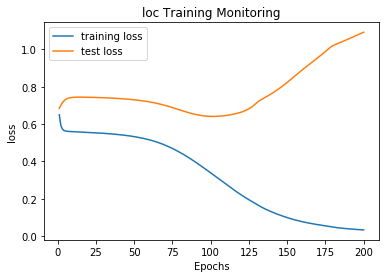

In [49]:
import matplotlib.pyplot as plt
x = list(range(1,len(tr_loss)+1))
plt.plot(x,tr_loss, label='training loss')
plt.plot(x,te_loss, label='test loss')
plt.ylabel('loss')
plt.xlabel('Epochs')
plt.title('loc Training Monitoring')
plt.legend()
plt.show()

### Accuracy on all loc data

In [50]:
pre = Lmodel(loc_fea)
loc_data['pre']=pre.detach().numpy().reshape(1,-1)[0].tolist()

In [51]:
cls = lambda x: 0 if x<=0.5 else 1
# loc_data["ori_cla"]=loc_data.qPCR.apply(cls)
loc_data["pre_cla"]=loc_data.pre.apply(cls)

In [52]:
# fill in your code...
Y_te = loc_data["ori_cla"].values.tolist()
preds_te = loc_data["pre_cla"].values.tolist()
print('Accuracy:', accuracy_score(Y_te,preds_te))
print('Precision:', precision_score(Y_te,preds_te))
print('Recall:', recall_score(Y_te,preds_te))
print('F1-Score:', f1_score(Y_te,preds_te))

Accuracy: 0.8571428571428571
Precision: 0.8571428571428571
Recall: 0.631578947368421
F1-Score: 0.7272727272727273


### Accuracy on loc test data

In [53]:
testpre = Lmodel(test_fea)
test_data['pre'] = testpre.detach().numpy().reshape(1,-1)[0].tolist()

cls = lambda x: 0 if x<=0.5 else 1
test_data["pre_cla"]=test_data.pre.apply(cls)
# fill in your code...
Y_te = test_data["ori_cla"].values.tolist()
preds_te = test_data["pre_cla"].values.tolist()
print('Accuracy:', accuracy_score(Y_te,preds_te))
print('Precision:', precision_score(Y_te,preds_te))
print('Recall:', recall_score(Y_te,preds_te))
print('F1-Score:', f1_score(Y_te,preds_te))

Accuracy: 0.5263157894736842
Precision: 0.3333333333333333
Recall: 0.125
F1-Score: 0.18181818181818182


## Using transfer learning

In [54]:
print(model)

LogisticModel(
  (l1): Linear(in_features=30, out_features=20, bias=True)
  (l2): Linear(in_features=20, out_features=10, bias=True)
  (l3): Linear(in_features=10, out_features=1, bias=True)
  (sigmoid): Sigmoid()
)


In [55]:
for param in model.parameters():
    param.requires_grad = False

In [57]:
num_ftrs = model.l3.in_features

In [58]:
model.l3 =  torch.nn.Sequential(nn.Linear(num_ftrs, 5),
                                    nn.Sigmoid(),
                                       torch.nn.Linear(5, 1))
 

In [59]:
model

LogisticModel(
  (l1): Linear(in_features=30, out_features=20, bias=True)
  (l2): Linear(in_features=20, out_features=10, bias=True)
  (l3): Sequential(
    (0): Linear(in_features=10, out_features=5, bias=True)
    (1): Sigmoid()
    (2): Linear(in_features=5, out_features=1, bias=True)
  )
  (sigmoid): Sigmoid()
)

In [60]:
# MSE/均方差
#criterion = nn.MSELoss()

# 优化(找到最小化差值的参数)
#learning_rate = 0.1  # 学习率, 达到最佳参数的速度有多快
#optimizer = torch.optim.SGD(model.parameters(),lr = learning_rate)

criterion = torch.nn.BCELoss(size_average=True)
optimizer = torch.optim.SGD(model.parameters(), lr=0.01)

In [61]:
def loc_train(epoch, model, trainloader):
    model.train()
    train_loss = 0
    for batch_idx, (inputs, targets) in enumerate(trainloader):
        inputs, targets = inputs.to('cpu'), targets.to('cpu')
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
        print('Train: Epoch: %d| train_loss: %f'% (epoch, train_loss))
    return train_loss

In [62]:
model = model.to("cpu")

In [63]:
tr_loss_tl = []
te_loss_tl = []
for e in range(200):
    loss = loc_train(epoch=e, model=model, trainloader=loc_trainloader)
    tr_loss_tl.append(loss)
    teloss = test(epoch=e, model=model, testloader=loc_testloader)
    te_loss_tl.append(teloss)

Train: Epoch: 0| train_loss: 0.621484
-----------------------------------------------Test: Epoch: 0| test loss: 0.679
Train: Epoch: 1| train_loss: 0.620876
-----------------------------------------------Test: Epoch: 1| test loss: 0.679
Train: Epoch: 2| train_loss: 0.620273
-----------------------------------------------Test: Epoch: 2| test loss: 0.679
Train: Epoch: 3| train_loss: 0.619678
-----------------------------------------------Test: Epoch: 3| test loss: 0.679
Train: Epoch: 4| train_loss: 0.619089
-----------------------------------------------Test: Epoch: 4| test loss: 0.679
Train: Epoch: 5| train_loss: 0.618507
-----------------------------------------------Test: Epoch: 5| test loss: 0.679
Train: Epoch: 6| train_loss: 0.617931
-----------------------------------------------Test: Epoch: 6| test loss: 0.679
Train: Epoch: 7| train_loss: 0.617361
-----------------------------------------------Test: Epoch: 7| test loss: 0.679
Train: Epoch: 8| train_loss: 0.616797
------------------

-----------------------------------------------Test: Epoch: 68| test loss: 0.686
Train: Epoch: 69| train_loss: 0.591777
-----------------------------------------------Test: Epoch: 69| test loss: 0.686
Train: Epoch: 70| train_loss: 0.591487
-----------------------------------------------Test: Epoch: 70| test loss: 0.687
Train: Epoch: 71| train_loss: 0.591201
-----------------------------------------------Test: Epoch: 71| test loss: 0.687
Train: Epoch: 72| train_loss: 0.590917
-----------------------------------------------Test: Epoch: 72| test loss: 0.687
Train: Epoch: 73| train_loss: 0.590636
-----------------------------------------------Test: Epoch: 73| test loss: 0.687
Train: Epoch: 74| train_loss: 0.590358
-----------------------------------------------Test: Epoch: 74| test loss: 0.687
Train: Epoch: 75| train_loss: 0.590084
-----------------------------------------------Test: Epoch: 75| test loss: 0.687
Train: Epoch: 76| train_loss: 0.589812
----------------------------------------

Train: Epoch: 136| train_loss: 0.577703
-----------------------------------------------Test: Epoch: 136| test loss: 0.697
Train: Epoch: 137| train_loss: 0.577558
-----------------------------------------------Test: Epoch: 137| test loss: 0.697
Train: Epoch: 138| train_loss: 0.577413
-----------------------------------------------Test: Epoch: 138| test loss: 0.698
Train: Epoch: 139| train_loss: 0.577270
-----------------------------------------------Test: Epoch: 139| test loss: 0.698
Train: Epoch: 140| train_loss: 0.577129
-----------------------------------------------Test: Epoch: 140| test loss: 0.698
Train: Epoch: 141| train_loss: 0.576989
-----------------------------------------------Test: Epoch: 141| test loss: 0.698
Train: Epoch: 142| train_loss: 0.576851
-----------------------------------------------Test: Epoch: 142| test loss: 0.698
Train: Epoch: 143| train_loss: 0.576713
-----------------------------------------------Test: Epoch: 143| test loss: 0.698
Train: Epoch: 144| train

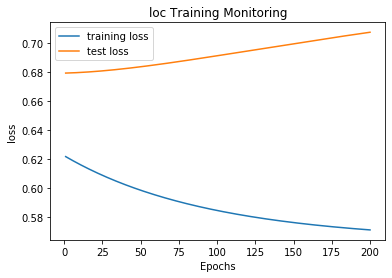

In [64]:
import matplotlib.pyplot as plt
x = list(range(1,len(tr_loss_tl)+1))
plt.plot(x,tr_loss_tl, label='training loss')
plt.plot(x,te_loss_tl, label='test loss')
plt.ylabel('loss')
plt.xlabel('Epochs')
plt.title('loc Training Monitoring')
plt.legend()
plt.show()

# Accuracy

In [65]:
pre = model(loc_fea)
loc_data['pre']=pre.detach().numpy().reshape(1,-1)[0].tolist()

In [66]:
cls = lambda x: 0 if x<=0.5 else 1
# loc_data["ori_cla"]=loc_data.qPCR.apply(cls)
loc_data["pre_cla"]=loc_data.pre.apply(cls)

In [67]:
# fill in your code...
Y_te = loc_data["ori_cla"].values.tolist()
preds_te = loc_data["pre_cla"].values.tolist()
print('Accuracy:', accuracy_score(Y_te,preds_te))
print('Precision:', precision_score(Y_te,preds_te))
print('Recall:', recall_score(Y_te,preds_te))
print('F1-Score:', f1_score(Y_te,preds_te))

Accuracy: 0.6984126984126984
Precision: 0.0
Recall: 0.0
F1-Score: 0.0


In [68]:
testpre = model(test_fea)
test_data['pre'] = testpre.detach().numpy().reshape(1,-1)[0].tolist()
cls = lambda x: 0 if x<=0.5 else 1
test_data["pre_cla"]=test_data.pre.apply(cls)

# fill in your code...
Y_te = test_data["ori_cla"].values.tolist()
preds_te = test_data["pre_cla"].values.tolist()
print('Accuracy:', accuracy_score(Y_te,preds_te))
print('Precision:', precision_score(Y_te,preds_te))
print('Recall:', recall_score(Y_te,preds_te))
print('F1-Score:', f1_score(Y_te,preds_te))

Accuracy: 0.5789473684210527
Precision: 0.0
Recall: 0.0
F1-Score: 0.0
